In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, Bidirectional, LSTM, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.backend import ctc_batch_cost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from Levenshtein import distance as levenshtein_distance
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from datetime import datetime

In [2]:
def get_paths_labels_vocab(txt_file_path, imgs_path, no_words=-1):
    """
    :param txt_file_path: words.txt file containing image identifiers and labels.
    :param imgs_path: Directory where the images are stored.
    :return: An array containing list of image paths and corresponding labels,
             a set of unique characters in the labels, and the maximum label length.
    """
    dataset, vocab, max_len = [], set(), 0
    
    words = open(sentences_txt_path, "r").readlines()

    for line in tqdm(words[:no_words]):
        if line.startswith("#"):
            continue
        line_split = line.split(" ")
        if line_split[1] == 'err':
            continue
        folder1 = line_split[0][:3]
        folder2 = "-".join(line_split[0].split("-")[:2])
        file_name = line_split[0] + ".png"
        label = line_split[-1].rstrip("\n")
        rel_path = os.path.join(sentences_folder_path, folder1, folder2, file_name)
        if not os.path.exists(rel_path):
            continue
        dataset.append([rel_path, label])
        vocab.update(list(label))
        max_len = max(max_len, len(label))

    return dataset, vocab, max_len

In [3]:
# 
def label_to_number(labels, vocab, max_len):
    """
    Function used to encode labels (change labels into numbers)
    
    :param labels: List of strings where each string represents a word to be encoded.
    :type labels: list of strings
    :param vocab: Set of characters that make up the vocabulary for encoding the labels.
    :type vocab: Set of characters
    :param max_len: Maximum length of the encoded labels. Shorter labels will be padded with -1.
    :type max_len: int
    
    :return: A numpy array where each element corresponds to a padded, encoded label.
    """
    vocab_dict = {char: idx for idx, char in enumerate(sorted(vocab))}
    encoded_labels = [[vocab_dict[char] for char in label] for label in labels]
    padded_labels = pad_sequences(encoded_labels, maxlen=max_len, padding='post', value=-1)  # Use -1 for padding
    return np.array(padded_labels)


def number_to_label(numbers, vocab):
    """
    :param numbers: A list of lists containing numerical representations of labels where -1 indicates padding .
    :type numbers: list of list with ints
    :param vocab: A list of characters representing the vocabulary to decode the numbers.
    :type vocab: list of str
    :return: A list of NumPy arrays where each array contains characters corresponding to the input numbers without the padding (-1).
    :rtype: numpy.ndarray
    """
    vocab_dict = {idx: char for idx, char in enumerate(sorted(vocab))}
    decoded_labels = ["".join([vocab_dict[num] for num in number if num != -1]) for number in numbers]
    return decoded_labels

# Use example
example_labels = ['testowy','hello','world']
example_vocab = {'t','e','s','t','o','w','y','h','e','l','l','o','w','o','r','l','d'}
example_max_len = len(max(example_labels,key=len))
print(f"Labels: {example_labels}")
print(f"Vocab {example_vocab}")
print(f"Max_len: {example_max_len}")
example_result = label_to_number(example_labels, example_vocab, example_max_len)
print(f"label_to_number():\n {example_result}")
print(f"number_to_label():\n {number_to_label(example_result, example_vocab)}")

example_labels = example_vocab = example_max_len = example_result = None

Labels: ['testowy', 'hello', 'world']
Vocab {'e', 'r', 't', 'w', 'o', 'h', 's', 'd', 'y', 'l'}
Max_len: 7
label_to_number():
 [[ 7  1  6  7  4  8  9]
 [ 2  1  3  3  4 -1 -1]
 [ 8  4  5  3  0 -1 -1]]
number_to_label():
 ['testowy', 'hello', 'world']


In [4]:
def load_images(image_paths, target_size=(128, 32), padding_color=255, binarize=False, otsu_adjustment=0):
    images = []
    valid_paths = []
    for path in image_paths:
        try:
            img = load_img(path, color_mode='grayscale')
            img_array = img_to_array(img).squeeze()
            h, w = img_array.shape[:2]
            scale = min(target_size[1] / h, target_size[0] / w)
            new_w = int(w * scale)
            new_h = int(h * scale)
            resized_img = cv2.resize(img_array, (new_w, new_h), interpolation=cv2.INTER_AREA)
            
            # Padding
            padded_img = np.full((target_size[1], target_size[0]), padding_color, dtype=np.uint8)
            pad_top = (target_size[1] - new_h) // 2
            pad_left = (target_size[0] - new_w) // 2
            padded_img[pad_top:pad_top + new_h, pad_left:pad_left + new_w] = resized_img
            
            # Binarization if specified
            if binarize:
                # GaussianBlur for noise reduction
                # blurred_img = cv2.GaussianBlur(padded_img, (3, 3), 0)
                blurred_img = padded_img
                
                # Otsu's Threshold with adjustment
                otsu_thresh, _ = cv2.threshold(
                    blurred_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
                )
                adjusted_thresh = max(0, min(255, otsu_thresh + 10))  # Slightly adjust the threshold
                _, binary_img = cv2.threshold(
                    blurred_img, adjusted_thresh, 255, cv2.THRESH_BINARY_INV
                )
            
                # Skeletonization
                skel = np.zeros_like(binary_img)
                element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
                while True:
                    open_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, element)
                    temp = cv2.subtract(binary_img, open_img)
                    eroded = cv2.erode(binary_img, element)
                    skel = cv2.bitwise_or(skel, temp)
                    binary_img = eroded.copy()
                    if cv2.countNonZero(binary_img) == 0:
                        break
            
                # Combine binary skeleton with original
                combined_img = cv2.addWeighted(padded_img.astype(np.float32) / 255.0, 0.7,
                                               1 - skel.astype(np.float32) / 255.0, 0.3, 0)
            
                # Normalize the result to [0, 1]
                padded_img = combined_img
            else:
                # Normalize to [0, 1]
                padded_img = padded_img / 255.0
                
            padded_img = np.expand_dims(padded_img, axis=-1)
            images.append(padded_img)
            valid_paths.append(path)

        except Exception as e:
            print(f"Skipping invalid or missing image: {path}. Error: {e}")
    
    return np.array(images), valid_paths

# TESTY
    
# images, valid_paths = load_images(X, target_size=(128, 32), padding_color=255, binarize=True, otsu_adjustment=-15)


# def display_images_with_labels(images, labels, max_images=10, cols=5):
#     """
#     Display images alongside their corresponding labels.
#     :param images: List of images to display.
#     :param labels: List of labels corresponding to the images.
#     :param max_images: Maximum number of images to display.
#     :param cols: Number of columns in the grid.
#     """
#     num_images = min(len(images), max_images)
#     rows = (num_images + cols - 1) // cols  # Compute number of rows
#     plt.figure(figsize=(15, rows * 3))
    
#     for i in range(num_images):
#         plt.subplot(rows, cols, i + 1)
#         plt.imshow(images[i].squeeze(), cmap="gray")
#         plt.title(labels[i], fontsize=10)
    
#     plt.tight_layout()
#     plt.show()

# # Display a sample of 10 images and their labels
# display_images_with_labels(images, y, max_images=100, cols=5)

![Przykładowy obraz](example.png)

In [5]:
def calculate_levenshtein_metric(y_true, y_pred):
    """
    Function to calculate Levenshtein metric
    :param y_true: List of true values.
    :param y_pred: List of predicted values.
    :return: Mean of the Levenshtein distances between the true and predicted values.
    """
    distances = [levenshtein_distance(true, pred) for true, pred in zip(y_true, y_pred)]
    return np.mean(distances)

In [6]:
# Function for CTC loss
def ctc_loss(y_true, y_pred):
    """
    :param y_true: tf of true labels, with shape (batch_size, max_label_length). The padding character is -1.
    :param y_pred: tf of predicted labels, with shape (batch_size, time_steps, num_classes).
    :return: CTC (connectionist temporal classification) loss for batch.
    """
    batch_size = tf.shape(y_true)[0]
    input_length = tf.fill([batch_size, 1], tf.shape(y_pred)[1])
    label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, -1), tf.int32), axis=1, keepdims=True)
    return ctc_batch_cost(y_true, y_pred, input_length, label_length)


In [7]:
def create_cnn_model(vocab, input_shape=(128, 32, 1)):
    """
    Build the OCR model architecture.

    :param vocab: Used for determining size of the vocabulary.
    :param input_shape: Tuple representing the shape of input data (height, width, channels).
    :return: Compiled Keras model.
    """
    
    vocab_size = len(vocab) + 1  # +1 for padding character if was '-1'
    
    model = Sequential([
        Input(input_shape),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Reshape((-1, 256)),
        Bidirectional(LSTM(256, return_sequences=True)),
        Dropout(0.5),
        Dense(vocab_size, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss=ctc_loss)
    return model


In [8]:
def plot_learning(history):
    plt.figure(figsize=(12, 6))
    
    # Krzywa strat dla zbioru treningowego i walidacyjnego
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    # Dodanie tytułów i etykiet
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Wyświetlenie wykresu
    plt.grid()
    plt.show()

In [9]:
# Load dataset
sentences_txt_path = os.path.join("Dataset", "words.txt")
sentences_folder_path = os.path.join("Dataset", "words")
no_words = -1
dataset, vocab, max_len = get_paths_labels_vocab(sentences_txt_path, sentences_folder_path, no_words)

X = [item[0] for item in dataset] # Get file paths
y = [item[1] for item in dataset] # Get labels

# Train test split
X_train_paths, X_val_paths, y_train_labels, y_val_labels = train_test_split(X, y, test_size=0.2, random_state=42)

# Load images; return successfully loaded images and valid paths 
X_train, valid_train_paths = load_images(X_train_paths, target_size=(128, 32), padding_color=255, binarize=True, otsu_adjustment=-25)
X_val, valid_val_paths = load_images(X_val_paths, target_size=(128, 32), padding_color=255, binarize=True, otsu_adjustment=-25)

# Update paths
y_train_filtered = [y_train_labels[X_train_paths.index(path)] for path in valid_train_paths]
y_val_filtered = [y_val_labels[X_val_paths.index(path)] for path in valid_val_paths]

# Change words into numbers
y_train = label_to_number(y_train_filtered, vocab, max_len)
y_val = label_to_number(y_val_filtered, vocab, max_len)

# Create and train model
model = create_cnn_model(vocab)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[reduce_lr, early_stopping])
predictions = model.predict(X_val)

# from tensorflow.keras.models import load_model
# model_path = "my_model_v1.keras"
# model = load_model(model_path,custom_objects={"ctc_loss": ctc_loss})
# predictions = model.predict(X_val)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115337/115337 [00:43<00:00, 2665.14it/s]


Skipping invalid or missing image: Dataset\words\g06\g06-018j\g06-018j-08-05.png. Error: not enough values to unpack (expected 2, got 0)
Skipping invalid or missing image: Dataset\words\g06\g06-018f\g06-018f-05-12.png. Error: not enough values to unpack (expected 2, got 0)
Skipping invalid or missing image: Dataset\words\b03\b03-114\b03-114-03-01.png. Error: not enough values to unpack (expected 2, got 0)
Skipping invalid or missing image: Dataset\words\l07\l07-176\l07-176-01-02.png. Error: not enough values to unpack (expected 2, got 0)
Skipping invalid or missing image: Dataset\words\l07\l07-176\l07-176-04-06.png. Error: not enough values to unpack (expected 2, got 0)
Skipping invalid or missing image: Dataset\words\g06\g06-018h\g06-018h-02-12.png. Error: not enough values to unpack (expected 2, got 0)
Skipping invalid or missing image: Dataset\words\a02\a02-120\a02-120-10-04.png. Error: not enough values to unpack (expected 2, got 0)
Skipping invalid or missing image: Dataset\words\

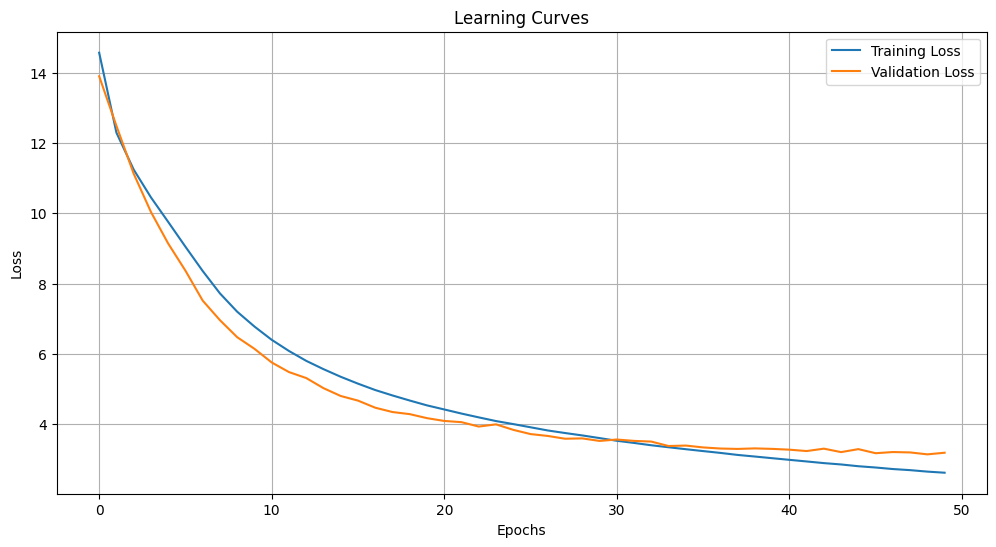

In [22]:
from datetime import datetime

current_date = datetime.now()

model.save(f"model{current_date.strftime('%m_%d__%H_%M')}.h5")
model.save(f"model{current_date.strftime('%m_%d__%H_%M')}.keras")

plot_learning(history)

In [11]:
def prediction_vector_to_label(predictions, vocab):
    prediction_sentences = []
    for seq in predictions:
        decoded_seq = []
        for char in np.argmax(seq, axis=-1):
            if char != len(vocab):  # Ignore blank
                try:
                    decoded_seq.append(int(char))
                except ValueError:
                    pass
        prediction_sentences.append(decoded_seq)
    
    return number_to_label(prediction_sentences, vocab)

In [12]:
prediction_sentences = prediction_vector_to_label(predictions, vocab)
print(prediction_sentences[:10])
decoded_y_val = number_to_label(y_val,vocab)

mean_levenshtein_distance = calculate_levenshtein_metric(decoded_y_val, prediction_sentences)
print(f"Mean Levenshtein Distance: {mean_levenshtein_distance:.4f}")


['suuree', ',', 'duiiing', 'hheer', 'booty', 'aasttromony', 'miitts', 'Thhee', 'and', 'in']
Mean Levenshtein Distance: 1.5596


In [13]:
def plot_predictions(X_paths, y_true, y_pred, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(X_paths[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"True: {y_true[i]}\nPred: {y_pred[i]}")
    plt.show()

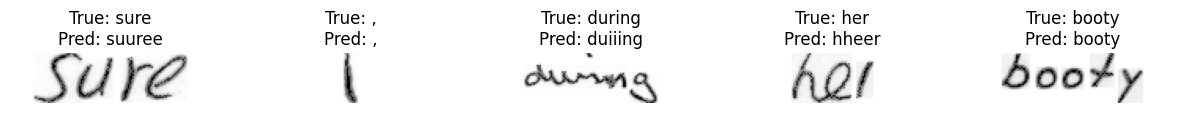

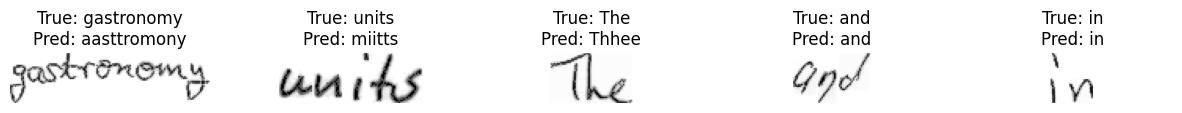

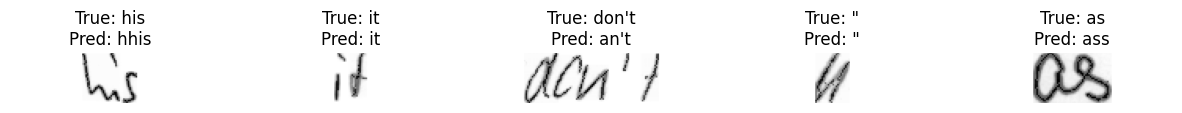

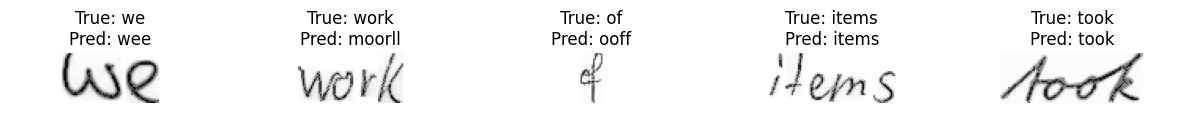

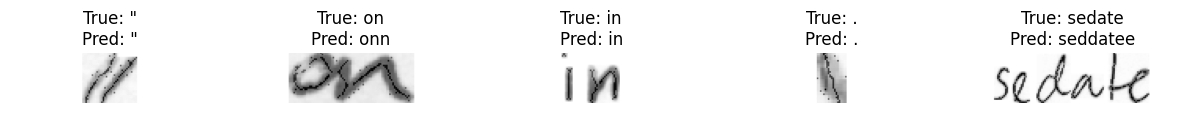

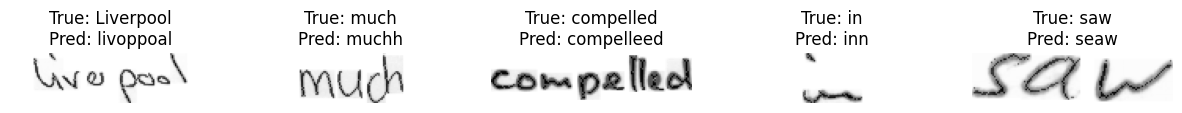

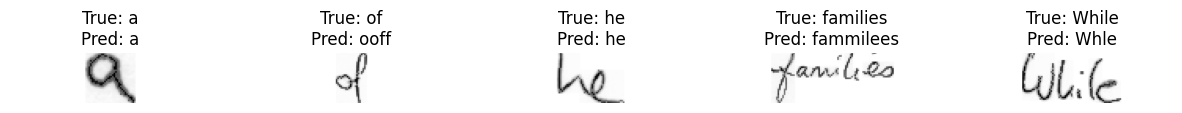

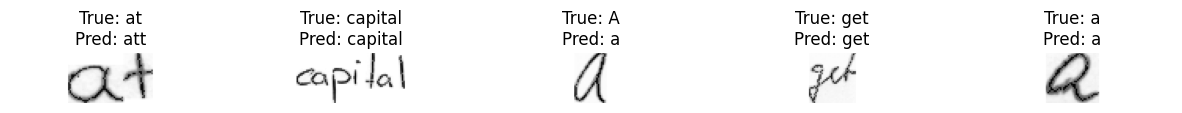

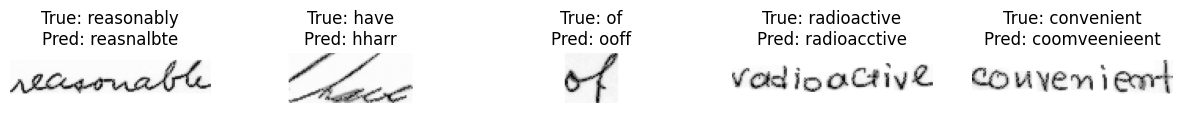

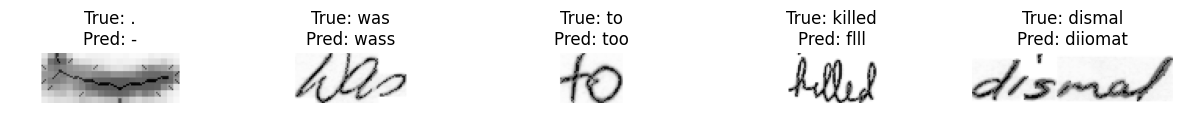

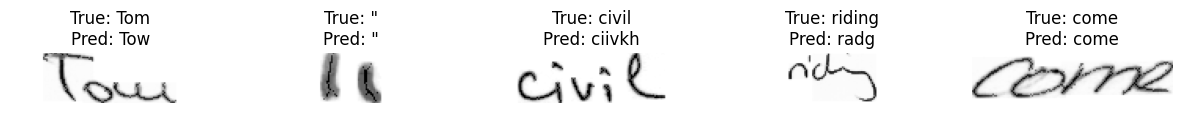

In [14]:
for i in range(0,51,5):
    plot_predictions(X_val[i:i + 5], decoded_y_val[i:i + 5], prediction_sentences[i:i + 5])